# SMOTE Experiment (with Resnet)

## Setup + Loading Data

In [1]:
!pip install -q tfds-nightly tensorflow-datasets matplotlib sklearn imblearn

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import imblearn
import math
import cv2

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9
PATIENCE = 50

In [3]:
!nvidia-smi

Tue Nov 16 08:16:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    86W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)
images, labels = ds['train'] # Type: EagerTensor

# Shuffle the dataset
images = tf.random.shuffle(images, seed=RANDOM_STATE)
labels = tf.random.shuffle(labels, seed=RANDOM_STATE)

print(images.shape, labels.shape)

(17509, 256, 256, 3) (17509,)


In [5]:
# Split dataset into train-val-test
num_images = images.shape[0]
last_train_image = math.floor(num_images * 0.6)
last_val_image = math.floor(num_images * 0.8)

X_train = images[:last_train_image]
y_train = labels[:last_train_image]
X_val = images[last_train_image:last_val_image]
y_val = labels[last_train_image:last_val_image]
X_test = images[last_val_image:]
y_test = labels[last_val_image:]

print(X_train.shape, X_val.shape, X_test.shape)

(10505, 256, 256, 3) (3502, 256, 256, 3) (3502, 256, 256, 3)


In [6]:
# Clean up memory usage
del ds
del images
del labels

## Applying SMOTE to a subsample of the original dataset

In [7]:
# Take out say 200 images
batch_size = 500

X_trainbatch = X_train[:batch_size]
y_trainbatch = y_train[:batch_size]
X_trainbatch = X_trainbatch.numpy()
y_trainbatch = y_trainbatch.numpy()
print(X_trainbatch.shape, y_trainbatch.shape)
print(type(X_trainbatch), type(y_trainbatch))

(500, 256, 256, 3) (500,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
# Flatten so that imblearn works on it
X_flattened = X_trainbatch.reshape(batch_size, -1)
print(X_flattened.shape)

(500, 196608)


In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = RANDOM_STATE)

In [10]:
# Original class distribution

labels, idx, counts = tf.unique_with_counts(y_trainbatch)
# Sort the labels and counts
sort_idx = tf.argsort(labels)
labels = tf.gather(labels, sort_idx)
counts = tf.gather(counts, sort_idx)
counts = counts.numpy().tolist()
print(labels)
print(counts)

tf.Tensor([0 1 2 3 4 5 6 7 8], shape=(9,), dtype=int64)
[33, 28, 21, 33, 27, 31, 37, 28, 262]


In [11]:
X_res, y_res = smote.fit_resample(X_flattened, y_trainbatch)
print(X_res.shape)

(2358, 196608)


In [12]:
X_res = X_res.reshape(X_res.shape[0], 256, 256, 3)
print(X_res.shape)

(2358, 256, 256, 3)


In [13]:
# New class distribution

abels, idx, counts = tf.unique_with_counts(y_res)
# Sort the labels and counts
sort_idx = tf.argsort(labels)
labels = tf.gather(labels, sort_idx)
counts = tf.gather(counts, sort_idx)
counts = counts.numpy().tolist()
print(labels)
print(counts)

tf.Tensor([0 1 2 3 4 5 6 7 8], shape=(9,), dtype=int64)
[262, 262, 262, 262, 262, 262, 262, 262, 262]


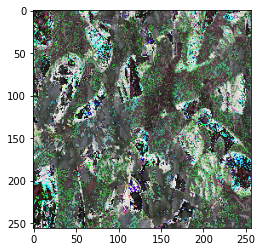

In [14]:
# Example of SMOTE image - doesn't look too realistic...hopefully the main features are still there
plt.imshow(X_res[2175])

In [15]:
# Comparing the greyscale image to the edges in the image - looks a bit messy
# because the images are interpolated

def conv_greyscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def sobel_filter(img, kernel_size):
    sobelx = cv2.Sobel(img, cv2.CV_64F,1,0, ksize = kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F,0,1, ksize = kernel_size)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    im_max = np.max(sobel)
    im_min = np.min(sobel)
    norm = (sobel - im_min)/(im_max - im_min)
    sobel = norm * 255
    return sobel

image = conv_greyscale(X_res[300])
filtered = sobel_filter(image, 3)

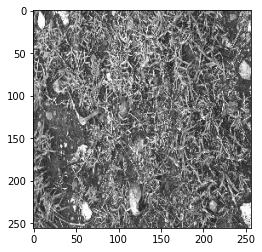

In [16]:
plt.imshow(image, cmap = "gray")

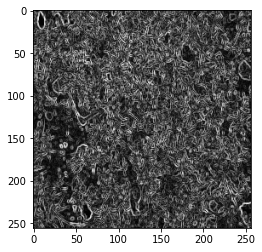

In [17]:
plt.imshow(filtered, cmap="gray")

## Applying Resnet on SMOTE-oversampled dataset

In [18]:
base_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = None)
base_model.trainable = False

In [19]:
# Create the model again using the Keras Functional API
# Image augmentation layers
rotation_layer = tf.keras.layers.RandomRotation(0.5, seed = RANDOM_STATE)
flipping_layer = tf.keras.layers.RandomFlip(seed = RANDOM_STATE)

# Prediction layers
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

inputs = tf.keras.Input(shape = (256, 256, 3))
x = flipping_layer(inputs)
x = rotation_layer(x)
x = base_model(x, training = False)
x = pooling_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

history = model.fit(x = X_res, y = y_res, validation_data = (X_val, y_val), 
                    epochs = 1000, callbacks = [early_stopping, reduce_lr])

Epoch 1/1000
74/74 [==============================] - 82s 697ms/step - loss: 1.7715 - accuracy: 0.3851 - val_loss: 1.2587 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 2/1000
74/74 [==============================] - 47s 643ms/step - loss: 1.0304 - accuracy: 0.6281 - val_loss: 1.1919 - val_accuracy: 0.5997 - lr: 0.0010
Epoch 3/1000
74/74 [==============================] - 47s 643ms/step - loss: 0.8870 - accuracy: 0.6819 - val_loss: 1.1026 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 4/1000
74/74 [==============================] - 47s 640ms/step - loss: 0.8051 - accuracy: 0.7239 - val_loss: 1.0998 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 5/1000
74/74 [==============================] - 47s 640ms/step - loss: 0.7466 - accuracy: 0.7299 - val_loss: 1.1130 - val_accuracy: 0.6348 - lr: 0.0010
Epoch 6/1000
74/74 [==============================] - 47s 639ms/step - loss: 0.6748 - accuracy: 0.7625 - val_loss: 1.1411 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 7/1000
74/74 [==============================] 

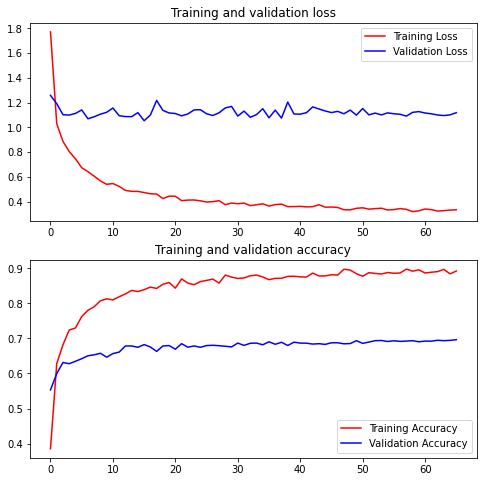

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index

print(y_pred)
print(classification_report(y_val, y_pred))

[4 8 8 ... 8 3 1]
              precision    recall  f1-score   support

           0       0.62      0.28      0.38       210
           1       0.57      0.48      0.52       228
           2       0.65      0.66      0.66       220
           3       0.58      0.28      0.38       193
           4       0.54      0.77      0.64       222
           5       0.82      0.56      0.67       208
           6       0.66      0.64      0.65       235
           7       0.62      0.25      0.36       191
           8       0.72      0.86      0.78      1795

    accuracy                           0.68      3502
   macro avg       0.64      0.53      0.56      3502
weighted avg       0.68      0.68      0.66      3502



## Applying ResNet on non-oversampled dataset

In [23]:
base_model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = None)
base_model.trainable = False

# Create the model again using the Keras Functional API
# Image augmentation layers
rotation_layer = tf.keras.layers.RandomRotation(0.5, seed = RANDOM_STATE)
flipping_layer = tf.keras.layers.RandomFlip(seed = RANDOM_STATE)

# Prediction layers
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

inputs = tf.keras.Input(shape = (256, 256, 3))
x = flipping_layer(inputs)
x = rotation_layer(x)
x = base_model(x, training = False)
x = pooling_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0   

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = PATIENCE, restore_best_weights = True)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

history = model.fit(x = X_trainbatch, y = y_trainbatch, validation_data = (X_val, y_val), 
                    epochs = 1000, callbacks = [early_stopping, reduce_lr])

Epoch 1/1000
16/16 [==============================] - 38s 2s/step - loss: 1.8562 - accuracy: 0.4760 - val_loss: 1.4445 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 2/1000
16/16 [==============================] - 31s 2s/step - loss: 1.3795 - accuracy: 0.5260 - val_loss: 1.2835 - val_accuracy: 0.5585 - lr: 0.0010
Epoch 3/1000
16/16 [==============================] - 31s 2s/step - loss: 1.1898 - accuracy: 0.5920 - val_loss: 1.1444 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 4/1000
16/16 [==============================] - 31s 2s/step - loss: 1.0574 - accuracy: 0.6240 - val_loss: 1.1173 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 5/1000
16/16 [==============================] - 45s 3s/step - loss: 0.9469 - accuracy: 0.6600 - val_loss: 1.0968 - val_accuracy: 0.6236 - lr: 0.0010
Epoch 6/1000
16/16 [==============================] - 31s 2s/step - loss: 0.9152 - accuracy: 0.6720 - val_loss: 1.1183 - val_accuracy: 0.6214 - lr: 0.0010
Epoch 7/1000
16/16 [==============================] - 31s 2s/step - lo

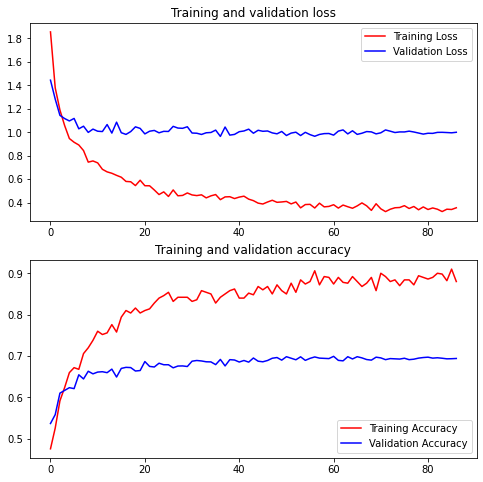

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index

print(y_pred)
print(classification_report(y_val, y_pred))

[4 7 8 ... 8 8 1]
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       210
           1       0.67      0.47      0.55       228
           2       0.86      0.53      0.66       220
           3       0.93      0.21      0.34       193
           4       0.51      0.76      0.61       222
           5       0.81      0.56      0.66       208
           6       0.69      0.48      0.57       235
           7       0.71      0.25      0.37       191
           8       0.71      0.90      0.79      1795

    accuracy                           0.69      3502
   macro avg       0.71      0.51      0.56      3502
weighted avg       0.71      0.69      0.67      3502



## Discussion
* Left (SMOTE) vs Right (no SMOTE), on a 500 image subsample of the dataset.
* SMOTE does not seem to make much of a difference at all
* F1 score of the minority classes does not seem to change much, which is surprising because the dataset is much more balanced now.


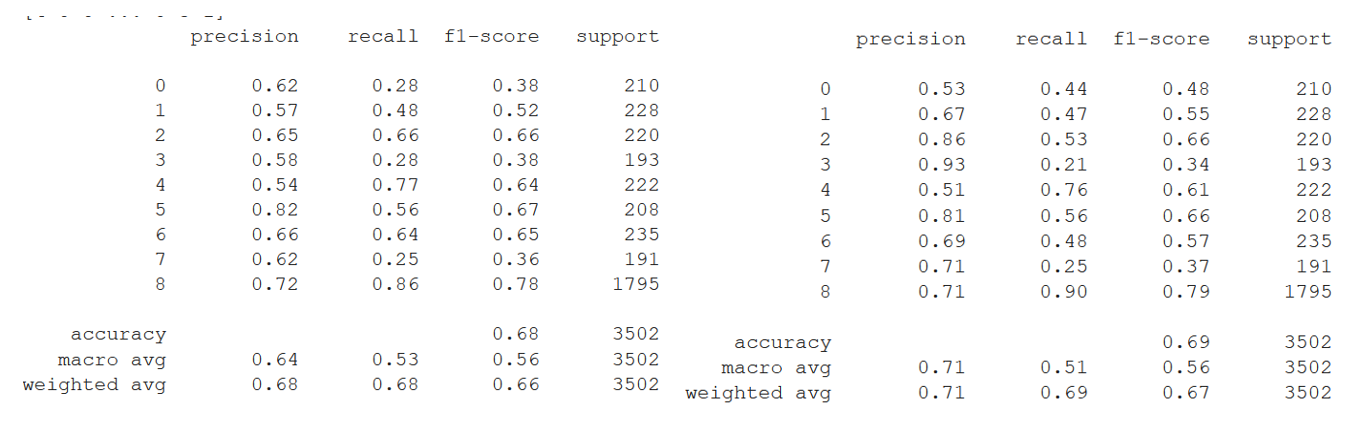